In [100]:
import requests
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.signal import savgol_filter

%matplotlib inline


In [101]:
now = int(time.time()*1000)
one_day = 24 * 60 * 60 * 1000
one_month_ago = now - (30 * one_day)
one_week_ago = now - (7 * one_day)

In [102]:
def get_data(start, end):
    r = requests.get('http://splat1.sto.midasplayer.com:8080/mysql/select/RBEA_CONSUMER_LAG?msts<={}&msts>={}'.format(end,start))
    return pd.DataFrame(r.json()['data'])

def get_values(df, env,topic):
    df2 = df[(df.environment == env) & (df.topic == topic)]
    df2.index = [datetime.fromtimestamp(ts/1000.0) for ts in list(df2.msts)]
    df2 = df2.sort_index()
    return df2.aggregatedValue

def calculate_uptime(df, env, topic):
    values = get_values(df, env,topic )
    filtered = savgol_filter(values, 5, 1)
    reference = savgol_filter(values, 1001, 1)
    diff = np.maximum(0, (filtered/reference) - 1)
    num_elements = len(values)
    return [100*(1.0 - (sum((diff > i))/num_elements)) for i in range(1,25)]


In [103]:
df = get_data(one_month_ago, now)

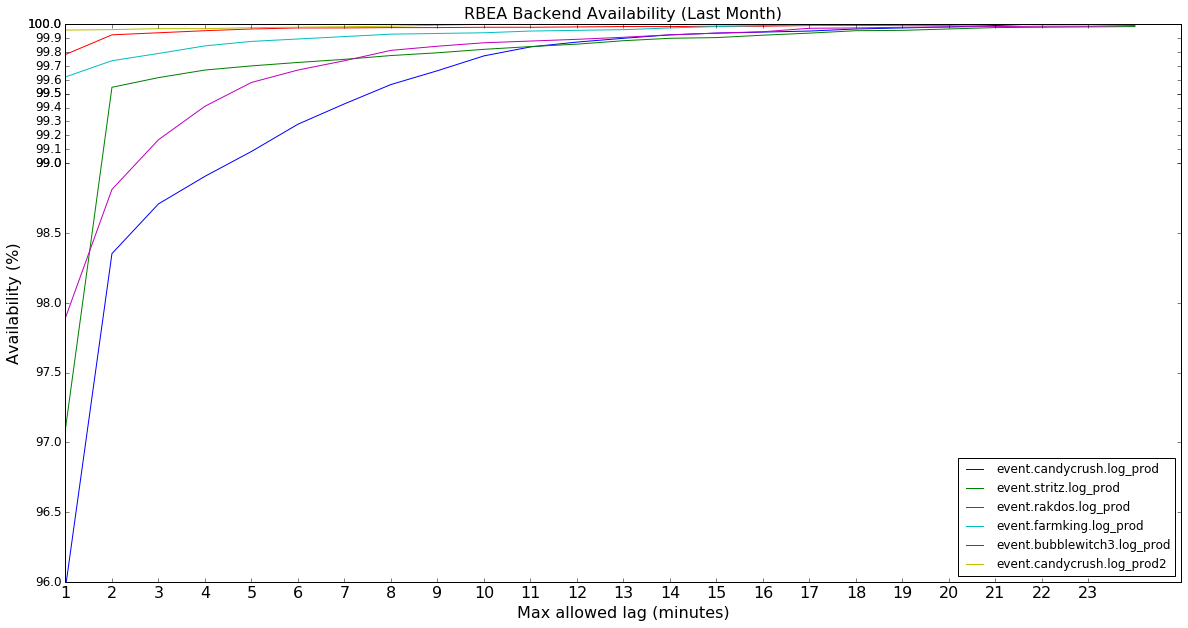

In [104]:
topics = ['event.candycrush.log', 'event.stritz.log', 'event.rakdos.log', 'event.farmking.log', 'event.bubblewitch3.log']

plt.figure(figsize=(20,10))
plt.ylabel('Availability (%)', fontsize=16)
plt.title('RBEA Backend Availability (Last Month)', fontsize=16)
plt.ylim(96,100)
plt.yticks(list(np.arange(96.,100.5,0.5))+ list(np.arange(99.,100.01,0.1)), fontsize=12)

plt.xlabel('Max allowed lag (minutes)', fontsize=16)
plt.xticks(range(1,24), fontsize=16)
plt.xlim(1,25)
for topic in topics:
    plt.plot(range(1,25), calculate_uptime(df, 'prod', topic), label = topic + '_prod')
plt.plot(range(1,25), calculate_uptime(df, 'prod2', 'event.candycrush.log'), label = 'event.candycrush.log_prod2')
plt.legend(loc="lower right")